Sequential Decision Making - Submission Notebook
================================================



## Sequential Decision Making



This notebook will form part of your individual submission for the course. The notebook will roughly mimic the parts that are in the `PDF` worksheet. Your task is to complete the code that is missing in the parts below and answer the questions that we ask. The aim is **not** for you to **solve** the worksheet but rather for you to show your understanding of the material in the course, instead of re-running and aiming to get "perfect" results run things, make sure it is correct and then try to explain your results with a few sentences, what we are looking for is evidence of understanding not the **right** result.

Bayesian optimisation is the first practical use of statistical emulation that we will do in the course. It is a really powerful and useful technique clearly exemplifying the value of having a parametrisation of our *ignorance* about a specific problem so that we can address this. We will use a Gaussian process as a surrogate model but when you go through the notebook you will see that there is nothing in the methodology itself that is tied to this specific surrogage. Given that you have already implemented a Gaussian process model in the previous worksheet, feel free to use that code instead as I am sure it is much better than your Professors attempt at coding :-).

The task we are going to address is that of minimisation. We have some form of unknown function that we can query, we want to find the minimima of this function using as few queries as possible. This is a very general scenario, there is some entity that we can interact with and from this there is a specific quantity of interest that we are interested in.

We are going to use a simple one-dimensional function that you have seen in the lectures and also a classic two-dimensional optimisation function called the Rosenbrock function.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import rosen
from scipy.stats import norm
from scipy.spatial.distance import cdist
np.random.seed(1)

In [2]:
def f(X, noise=0.0):
    return -(-np.sin(3*X) - X**2 + 0.7*X + noise*np.random.randn(*X.shape))

### Surrogate model



In [3]:
def gpposterior(x_star, X, Y, theta, kernel, jitter=1e-8):
    k_starstar = kernel(x_star, x_star, theta)
    k_starX = kernel(x_star, X, theta)
    K = kernel(X, X, theta) + jitter * np.eye(len(X)) # jitter is introduced for stability
    # using cholesky algorithm as taught in the practical gaussian lab
    L = np.linalg.cholesky(K) 
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, Y))
    mu = k_starX.dot(alpha)
    v = np.linalg.solve(L, k_starX.T)
    varSigma = k_starstar - k_starX.dot(np.linalg.solve(K, k_starX.T))
    return mu, varSigma

For the co-variance function, you have already played around a bit with different co-variances in the previous lab, feel free to try a few different ones here as well. We will add one co-variance that you haven't seen before that is very commonly used in Bayesian Optimisation and that is the `Matern Class` of co-variances.



In [4]:
def matern32_kernel(x1, x2, theta):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return theta[0]*(1+np.sqrt(3)*d/theta[1])*np.exp(-np.sqrt(3)*d/theta[1])

def matern52_kernel(x1, x2, theta):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return theta[0]*(1+np.sqrt(5)*d/theta[1] + 5*d**2/(3*theta[1]**2))*np.exp(-np.sqrt(5)*d/theta[1])

def rbf_kernel(x1, x2, theta):
    if x2 is None:
        d2 = cdist(x1, x1)
    else:
        d2 = cdist(x1, x2)
    return theta[0] * np.exp(-0.5 * d2 ** 2 / (theta[1]**2))

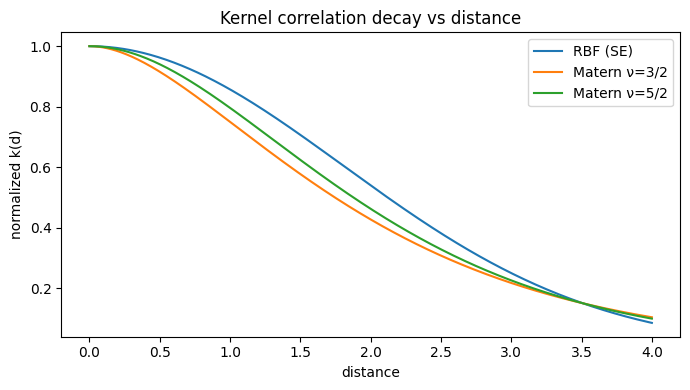

In [5]:
def kern_dist(kernel_fn, theta, d):
    x = d
    x0 = np.zeros((1, 1))
    k_d = kernel_fn(x, x0, theta).flatten()
    return k_d / k_d[0]

theta = np.array([1.5, 1.8])  # variance=1.0, lengthscale=1.2

d = np.linspace(0, 4.0, 500).reshape(-1, 1)
k_rbf = kern_dist(rbf_kernel, theta, d)
k_m32 = kern_dist(matern32_kernel, theta, d)
k_m52 = kern_dist(matern52_kernel, theta, d)

d = d.flatten()

plt.figure(figsize=(7,4))
plt.plot(d, k_rbf, label='RBF (SE)')
plt.plot(d, k_m32, label='Matern ν=3/2')
plt.plot(d, k_m52, label='Matern ν=5/2')
plt.xlabel('distance')
plt.ylabel('normalized k(d)')
plt.title('Kernel correlation decay vs distance')
plt.legend()
plt.tight_layout()
plt.show()

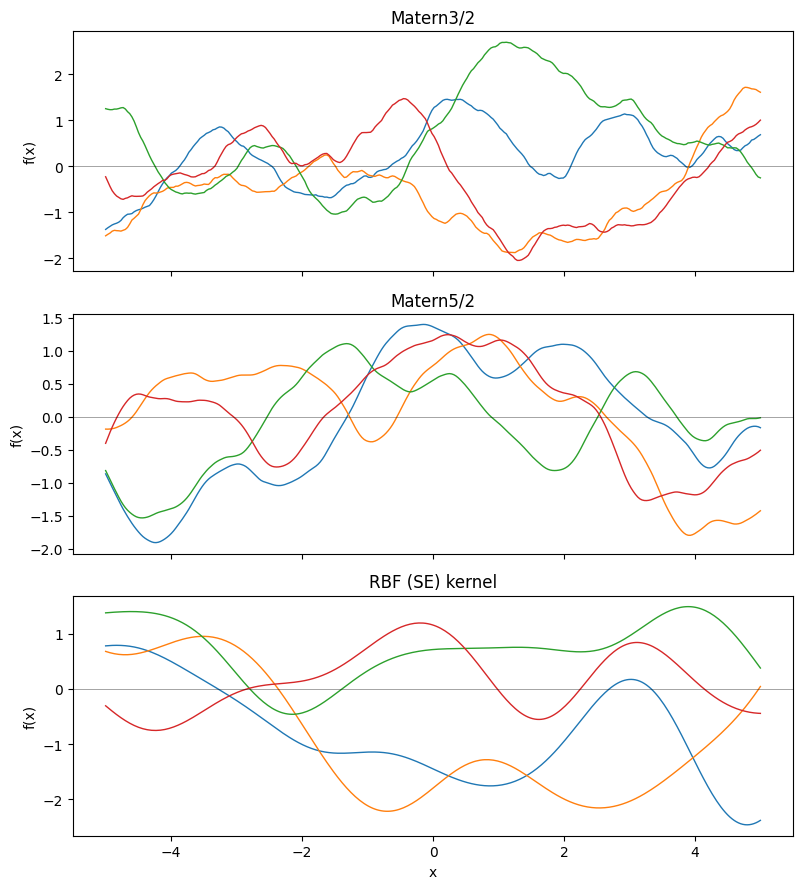

In [6]:
def sample_gp_prior(x, kernel_fn, theta, n_samples=4, jitter=1e-9):
    K = kernel_fn(x, x, theta) + jitter * np.eye(x.shape[0]) # jitter for stability
    mean = np.zeros(x.shape[0])
    return np.random.multivariate_normal(mean, K, size=n_samples)

x = np.linspace(-5, 5, 300).reshape(-1, 1)
theta = np.array([1.0, 1.2])  # variance=1.0, lengthscale=1.2

rbf_samples = sample_gp_prior(x, rbf_kernel, theta)
m32_samples = sample_gp_prior(x, matern32_kernel, theta)
m52_samples = sample_gp_prior(x, matern52_kernel, theta)

fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

for s in m32_samples:
    axes[0].plot(x, s, lw=1)
axes[0].axhline(0, color='k', lw=0.5, alpha=0.5)
axes[0].set_title('Matern3/2')

for s in m52_samples:
    axes[1].plot(x, s, lw=1)
axes[1].axhline(0, color='k', lw=0.5, alpha=0.5)
axes[1].set_title('Matern5/2')

for s in rbf_samples:
    axes[2].plot(x, s, lw=1)
axes[2].axhline(0, color='k', lw=0.5, alpha=0.5)
axes[2].set_title('RBF (SE) kernel')

for ax in axes:
    ax.set_ylabel('f(x)')
axes[-1].set_xlabel('x')
plt.tight_layout()
plt.show()

The Matern family of co-variances share a lot of the behaviour of the RBF, however compared to the former it is not infinitely differentiable which allows us to specify the degree of smoothness the function have allowing for a bit more "roughness" in the function. Actually the class is itself specified with a parameter controlling this and the RBF co-variance is the limiting behaviour of this parameter, so in some sense it is a generalisation of the RBF covariance. To get familiar with the co-variance do just as you did in the previous lab and draw some samples from it.

**Questions 1**
*Explain why you think the Matern co-variance might be a better co-variance function compared to the squared-exponential in the general case?*

**Answer**
The SE assumes the underlying function to be infinitely differentiable. This can sometimes be an overly optimistic assumption of real world trends, in fact many real world functions are not infinitely smooth, they can be jaggy and the functions could be piecewise/undifferentiable at certain points. Robotic arm movements can be one such example. Compared to SEs, the Matern family of covariances give us more granular control in our belief of the differentiability and smoothness of the system we are studying through the smoothness parameter nu.

Given that SEs are a special case of the Matern when nu tends to infinity, the Matern family generalises SE, it makes sense to start off with Matern kernels as they provide a safer default that adapts to roughness, however if we KNOW (highly confident) the function is extremely smooth, we should go with SE.


### Acquisition Function



When we have the surrogate model up and running it is time to think about the *strategy* that we use to interact with the function given that we have a surrogate. First lets think about how we can think about the problem at hand. Would it be possible to find the minima of a function given that we would not assume/believe anything about the structure of the function? No, in the case where we expect the minima to be anywhere we cannot get any reduced entropy about it by observing the function. So the key here is, we make assumptions about the function and then see how this leads to a reduced entropy of the minima. So lets look at the information that our function prior encodes.

What we will do is to observe a set of locations to start with, these are just chosen randomly. Then we compute the posterior distribution of the function for a set of location. We will then draw a large set of samples from this distribution, i.e. functions that are consistent with our updated belief given the observations we have seen.

As it is the minima we are interested in we will compute the location of the minima. This is of course not the minima of the actual function, it is only the minima among the slices that we are considering.



In [7]:
def sample_minima(X_train, y_train, X_grid, kernel, theta, n_samples=5000, seed=0):
    local_rng = np.random.RandomState(seed) # set seed for reproduceable results

    mu, cov = gpposterior(X_grid, X_train, y_train, theta, kernel)
    cov = cov + 1e-10 * np.eye(len(X_grid))
    
    mins_x = []
    
    for _ in range(n_samples):
        f_sample = local_rng.multivariate_normal(mu.flatten(), cov)
        min_idx = np.argmin(f_sample)
        mins_x.append(X_grid[min_idx, 0])
    
    mins_x = np.array(mins_x)
    var = np.clip(np.diag(cov), 0.0, np.inf)
    
    return mins_x, mu.flatten(), var




=== Trying Different Kernels ===



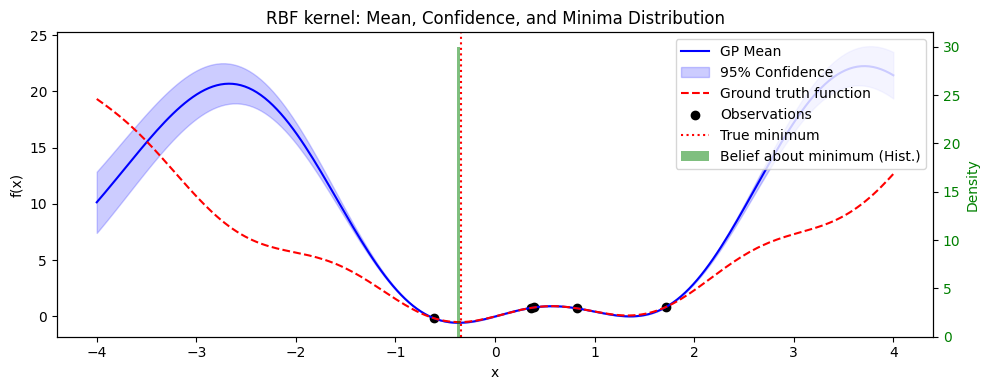

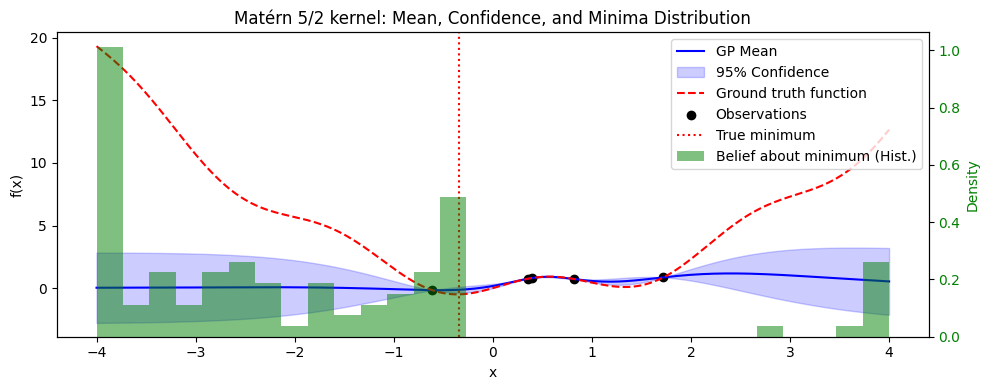

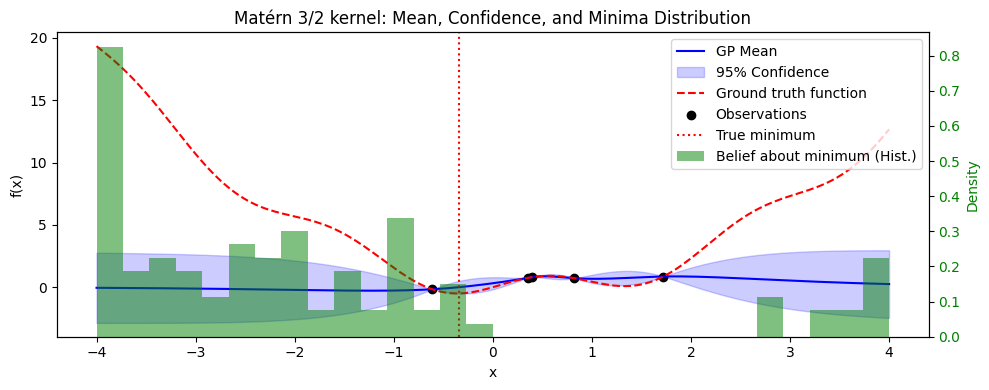


=== Trying Different Numbers of Initial Points ===



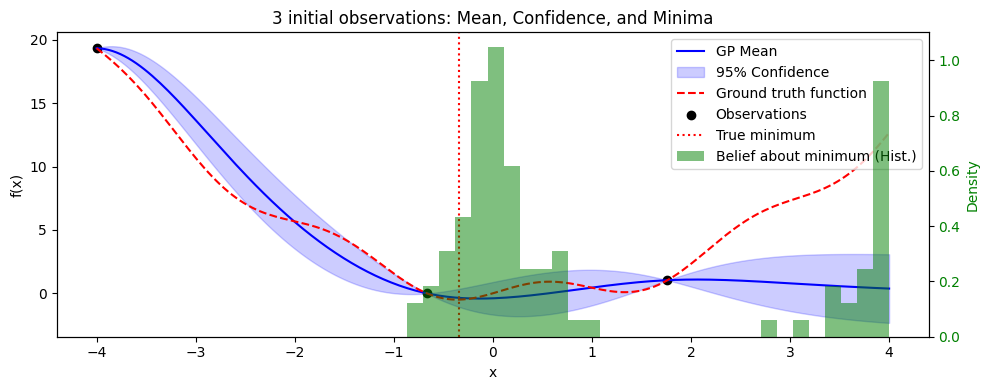

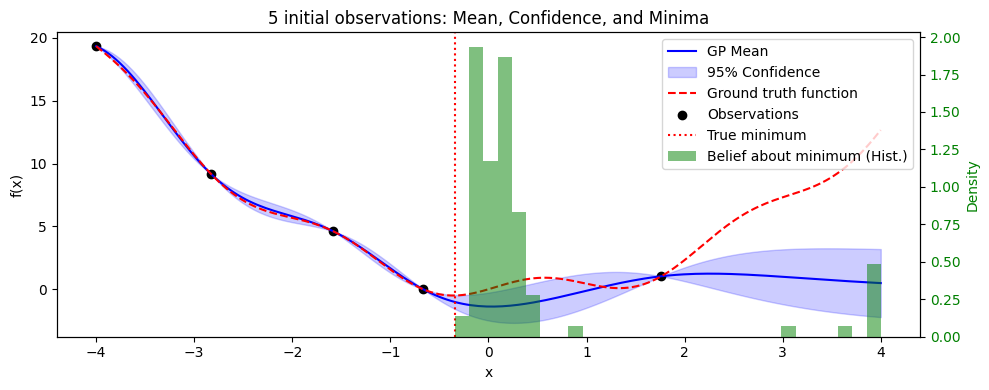

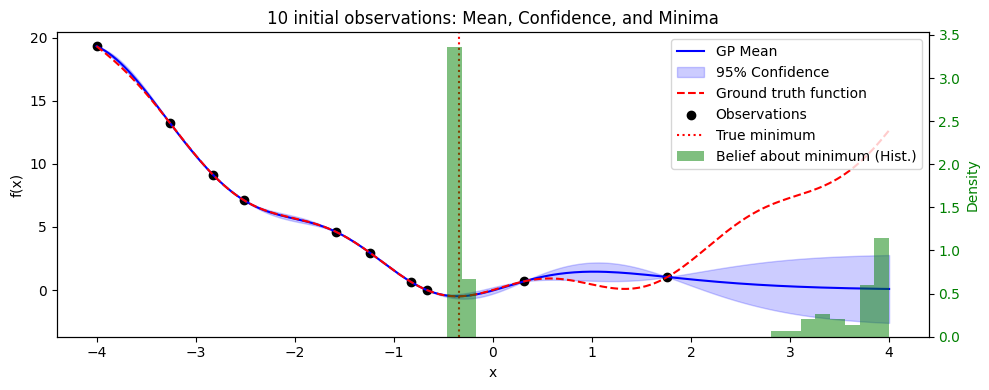

In [8]:
def plot_gp_sausage_and_minima(plot_x_range, 
                               x_observations, y_observations, 
                               sampled_minima_locations, 
                               gp_mean, gp_variance, 
                               true_minimum_x, 
                               title, hist_color='green'):
    """
    Plots the GP posterior (mean + confidence) and overlays
    the histogram of the belief about the minimum (using a twin axis).
    (Minimal version)
    """
    
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # --- Primary Y-Axis (ax1) for f(x) and GP "Sausage" ---
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')
    
    # --- Prepare data ---
    x_flat = plot_x_range.flatten()
    mean_flat = gp_mean.flatten()
    std_dev_flat = np.sqrt(np.maximum(gp_variance.flatten(), 0))
    
    # --- Plot the "Sausage" Plot ---
    ax1.plot(x_flat, mean_flat, 'b-', label='GP Mean')
    ax1.fill_between(x_flat, 
                     mean_flat - 2 * std_dev_flat, 
                     mean_flat + 2 * std_dev_flat, 
                     color='blue', alpha=0.2, label='95% Confidence')
    
    # --- Plot Data and True Function ---
    ax1.plot(x_flat, f(x_flat), 'r--', label='Ground truth function')
    ax1.scatter(x_observations, y_observations, c='black', label='Observations')
    ax1.axvline(true_minimum_x, color='red', linestyle=':', label='True minimum')
    
    # --- Secondary Y-Axis (ax2) for Histogram ONLY ---
    ax2 = ax1.twinx()
    ax2.set_ylabel(f'Density', color=hist_color)
    
    ax2.hist(sampled_minima_locations, bins=30, density=True, 
             alpha=0.5, color=hist_color, label='Belief about minimum (Hist.)')
    
    ax2.tick_params(axis='y', labelcolor=hist_color)
    ax2.set_ylim(bottom=0)

    # --- Combine legends (simple method) ---
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax1.set_title(title)
    fig.tight_layout()
    plt.show()


# --- Your original code to run the plots (no changes needed) ---

# Setup
plot_x_range = np.linspace(-4, 4, 200).reshape(-1, 1)
theta = np.array([2.0, 1.5]) # Hyperparameters
true_minimum_x = plot_x_range[np.argmin(f(plot_x_range)), 0]

print("\n================================\n")
print("\n=== Trying Different Kernels ===\n")

kernels = [
    (rbf_kernel, "RBF"),
    (matern52_kernel, "Matérn 5/2"),
    (matern32_kernel, "Matérn 3/2")
]

for kernel_func, kernel_name in kernels:
    rng = np.random.RandomState(0)
    x_observations = rng.uniform(-4, 4, size=(5, 1))
    y_observations = f(x_observations)
    
    sampled_minima_locations, gp_mean, gp_variance = sample_minima(
        x_observations, y_observations, plot_x_range, 
        kernel_func, theta, n_samples=100
    )
    
    plot_gp_sausage_and_minima(
        plot_x_range, x_observations, y_observations, 
        sampled_minima_locations, gp_mean, gp_variance, 
        true_minimum_x, 
        title=f'{kernel_name} kernel: Mean, Confidence, and Minima Distribution'
    )


print("\n=== Trying Different Numbers of Initial Points ===\n")

kernel_func = matern52_kernel

for n_initial_points in [3, 5, 10]:
    rng = np.random.RandomState(1)
    x_observations = rng.uniform(-4, 4, size=(n_initial_points, 1))
    y_observations = f(x_observations)
    
    sampled_minima_locations, gp_mean, gp_variance = sample_minima(
        x_observations, y_observations, plot_x_range, 
        kernel_func, theta, n_samples=100
    )
    
    plot_gp_sausage_and_minima(
        plot_x_range, x_observations, y_observations, 
        sampled_minima_locations, gp_mean, gp_variance, 
        true_minimum_x,
        title=f'{n_initial_points} initial observations: Mean, Confidence, and Minima'
    )

When you have computed the minima, plot the histogram of the values along the x-axis together with the mean and the marginal variance at each location. You can try this for a few different co-variance functions to see how the structure changes, also try to alter the number of points that you start with etc. just to get a feeling for the information that you have encoded about the minima from the different assumptions that you encode using the co-variance. You can also plot the underlying unknown function and see how well it reflects where the actual minima is.

From the argument that we did above, I hope that you agree that our belief over the function actually induces a relevant belief over the minima of the function. Now we want to come up with a strategy that allows us to iteratively query the function in relevant places to create an efficient search. To be a bit general we will think of a function, called the *acquisition function*, that will parametrise the strategy we use for the finding the minima. In specific, the function will provide a value telling us the "relative" value of querying a specific location in the input domain. 

Now lets considered the simplest strategy that does this is to rather than compute the empirical distribution of the minima and sample from this, just pick one of the sampled functions and use its minima. This is a technique referred to as *Thompson Sampling*. In terms of an acquisition this means that we will generate a function that has a non-zero value at the location of the minima of the sample and is zero everywhere else.



In [9]:
def thompson_sampling(mu, cov, **kwargs):
    cov_stable = cov + 1e-8 * np.eye(len(mu))
    f_sample = np.random.multivariate_normal(mu, cov_stable)
    alpha = np.zeros(len(mu))
    alpha[np.argmin(f_sample)] = 1.0
    return alpha

Now we have the two components that we need in order to write our iterative Bayesian Optmisation loop. We are going to be trying out a few different co-variance functions and acquisition strategies so if you can try to write the code in a general manner where these things are easy to swap out. Because we are using non-parametric surrogates, we have to decide upon a finite set of locations to evaluate our surrogate and acquisition function on. In effect we are trying to answer the question, *from a finite set locations $\{\mathbf{x}_i\in\mathcal{X}\}_{i=1}^N$ what is location that corresponds to the minimal function value in the set $\{\mathbf{x}_i\}_{i=1}^N$*. In practice we will just use a uniform grid as the sample location. Now lets implement the loop,



In [10]:
def bayesian_optimisation(kernel, theta, acquisition_function, X_grid, f, n_init=3, n_iter=5, seed=0):
    rng = np.random.RandomState(seed)
    
    # Initialize with random observations
    init_idx = rng.choice(X_grid.shape[0], size=n_init, replace=False)
    X_obs = X_grid[init_idx]
    y_obs = f(X_obs)

    # Optimization loop
    for iteration in range(n_iter):
        # Compute GP posterior
        mu, cov = gpposterior(X_grid, X_obs, y_obs, theta, kernel)
        
        # Compute acquisition (pass everything, let function decide what it needs)
        alpha = acquisition_function(mu=mu.flatten(), cov=cov, y_obs=y_obs)

        # Select next point
        x_idx = np.argmax(alpha)
        x_next = X_grid[x_idx:x_idx+1]

        # Evaluate and add observation
        y_next = f(x_next)
        X_obs = np.vstack([X_obs, x_next])
        y_obs = np.vstack([y_obs, y_next])

    # Return best found
    best_idx = np.argmin(y_obs)
    return y_obs[best_idx], X_obs[best_idx], X_obs, y_obs

--- Running Sequential Thompson Sampling ---
True minimum at x ≈ -0.3417


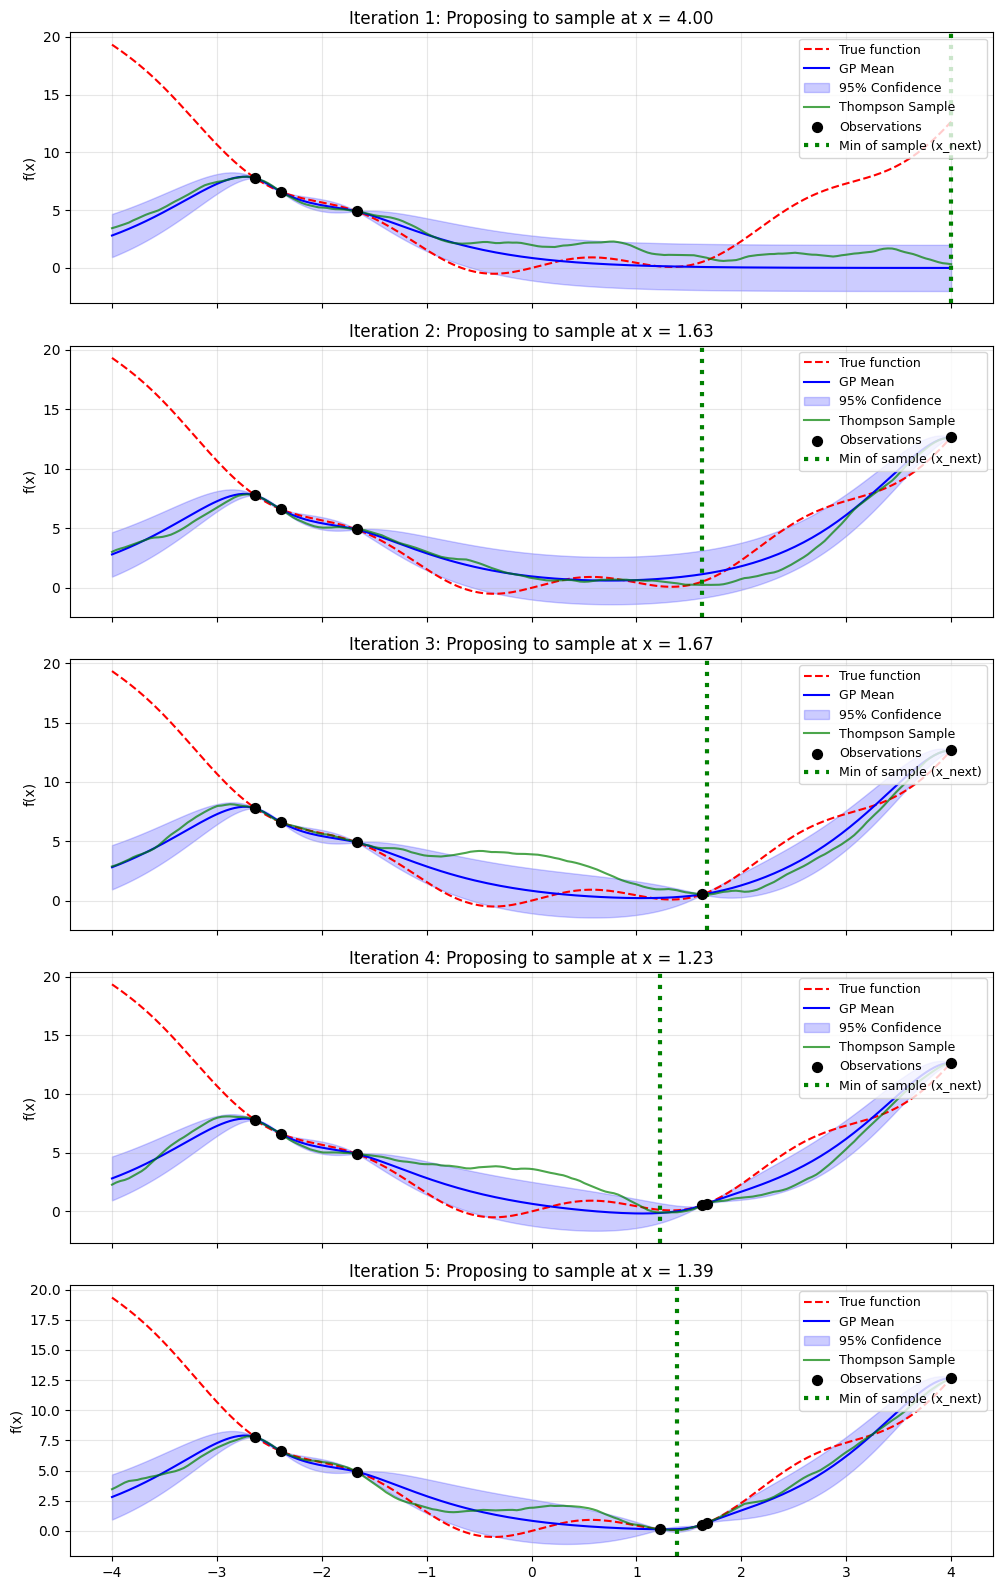

In [11]:
# ============================================================================
# VISUALIZATION: Sequential Thompson Sampling (Step-by-step demonstration)
# This code manually implements the BO loop with detailed plotting at each iteration
# to help understand how Thompson Sampling works. For experiments, use the 
# bayesian_optimisation() function defined above.
# ============================================================================

X_grid = np.linspace(-4, 4, 200).reshape(-1, 1)
true_y = f(X_grid)
true_minimum_x = X_grid[np.argmin(true_y)]

# Kernel parameters (variance, lengthscale)
theta = np.array([1.0, 1.0])

n_init = 3
n_iter = 5
np.random.seed(1) # For reproducible results

# Get initial random observations
X_obs = X_grid[np.random.choice(len(X_grid), n_init, replace=False)]
y_obs = f(X_obs).reshape(-1, 1)

# Store all observations
X_obs_all, y_obs_all = X_obs.copy(), y_obs.copy()

print("--- Running Sequential Thompson Sampling ---")
print(f"True minimum at x ≈ {true_minimum_x[0]:.4f}")

# --- Sequential Plotting Loop ---
fig, axes = plt.subplots(n_iter, 1, figsize=(10, 16), sharex=True)

for i in range(n_iter):
    ax = axes[i]
    
    # 1. Calculate GP posterior based on current observations
    mu, cov = gpposterior(X_grid, X_obs, y_obs, theta, matern32_kernel)
    std = np.sqrt(np.maximum(np.diag(cov), 0))
    
    # 2. Sample one function from the GP posterior for Thompson Sampling
    cov_stable = cov + 1e-8 * np.eye(len(mu))
    f_sample = np.random.multivariate_normal(mu.flatten(), cov_stable)
    
    # Find the minimum of this sample
    next_x_index = np.argmin(f_sample)
    next_x = X_grid[[next_x_index]]
    
    # --- Plotting for this iteration ---
    
    # Plot true function
    ax.plot(X_grid, true_y, 'r--', label='True function')
    
    # Plot GP "sausage" (the current belief)
    ax.plot(X_grid, mu, 'b-', label='GP Mean')
    ax.fill_between(X_grid.flatten(), mu.flatten() - 2*std, mu.flatten() + 2*std, 
                     color='blue', alpha=0.2, label='95% Confidence')
    
    # Plot the Thompson Sample that was drawn
    ax.plot(X_grid, f_sample, 'g-', alpha=0.7, 
             label='Thompson Sample')
    
    # Plot all observations so far
    ax.scatter(X_obs, y_obs, c='k', s=50, zorder=10, label='Observations')
    
    # Highlight the minimum of the sample (the next point to query)
    ax.axvline(next_x, color='green', linestyle=':', linewidth=3, 
                label=f'Min of sample (x_next)')
    
    ax.set_title(f'Iteration {i+1}: Proposing to sample at x = {next_x[0][0]:.2f}')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylabel('f(x)')

    # 3. Add the new observation for the *next* loop
    next_y = f(next_x)
    
    X_obs = np.vstack((X_obs, next_x))
    y_obs = np.vstack((y_obs, next_y))
    
    # Store for the final plot
    X_obs_all = np.vstack((X_obs_all, next_x))
    y_obs_all = np.vstack((y_obs_all, next_y))

fig.tight_layout()
plt.show()

Once you have confirmed that the loop is running in a way that you would expect try to alter the co-variance function, either its parameters or the type just so that you get and understanding of how the loop works.

True minimum: x = -0.3417, f(x) = -0.4988

--- Experiment 1: Comparing Kernel Types ---

RBF            : f* = -0.4978 at x = -0.3819
Matérn 3/2     : f* = -0.4978 at x = -0.3819
Matérn 5/2     : f* = -0.4842 at x = -0.3015


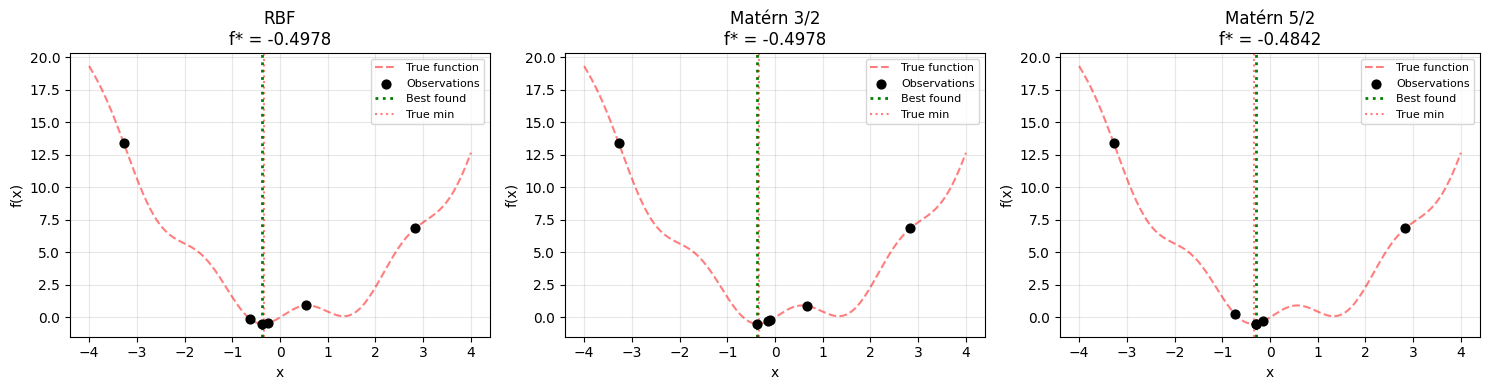


--- Experiment 2: Effect of Lengthscale ---

ℓ=0.3: f* = 0.6635
ℓ=0.7: f* = -0.4804
ℓ=1.0: f* = -0.4988
ℓ=1.5: f* = -0.4988
ℓ=2.5: f* = 0.0885


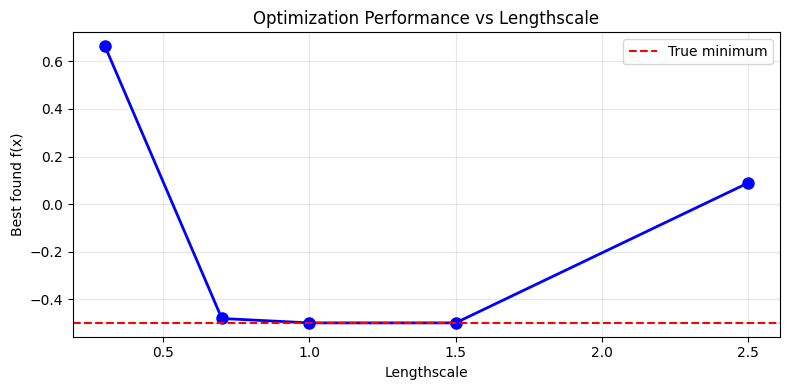


--- Experiment 3: Effect of Variance ---

σ²=0.5: f* = -0.4978
σ²=1.0: f* = -0.4549
σ²=2.0: f* = -0.2914
σ²=3.0: f* = -0.4988


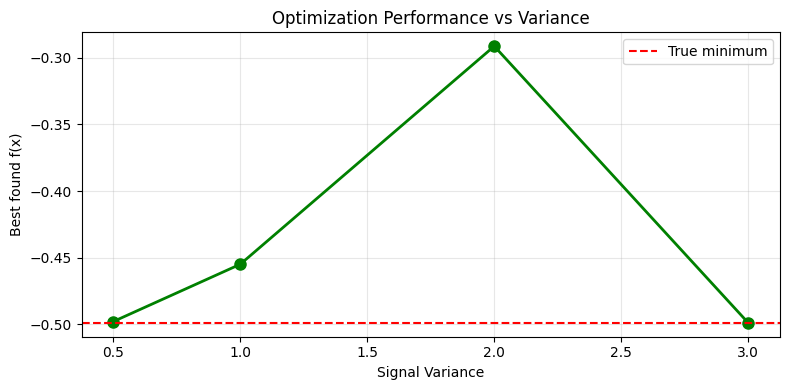


Summary: Different hyperparameters affect the GP's ability
to model the function and thus the optimization performance.


In [12]:
X_grid = np.linspace(-4, 4, 200).reshape(-1, 1)
true_y = f(X_grid)
true_minimum_x = X_grid[np.argmin(true_y)]
true_minimum_value = np.min(true_y)

print(f"True minimum: x = {true_minimum_x[0]:.4f}, f(x) = {true_minimum_value:.4f}\n")
print("--- Experiment 1: Comparing Kernel Types ---\n")

kernels_to_test = [
    (rbf_kernel, "RBF"),
    (matern32_kernel, "Matérn 3/2"),
    (matern52_kernel, "Matérn 5/2")
]
theta = np.array([1.0, 1.0])
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (kernel_func, kernel_name) in enumerate(kernels_to_test):
    f_min, x_min, X_obs, y_obs = bayesian_optimisation(
        kernel=kernel_func, theta=theta, acquisition_function=thompson_sampling,
        X_grid=X_grid, f=f, n_init=2, n_iter=4,
    )
    
    print(f"{kernel_name:15s}: f* = {f_min[0]:.4f} at x = {x_min[0]:.4f}")
    
    # Plot
    ax = axes[idx]
    ax.plot(X_grid, true_y, 'r--', alpha=0.5, label='True function')
    ax.scatter(X_obs, y_obs, c='black', s=40, zorder=5, label='Observations')
    ax.axvline(x_min, color='green', linestyle=':', linewidth=2, label='Best found')
    ax.axvline(true_minimum_x, color='red', linestyle=':', alpha=0.5, label='True min')
    ax.set_title(f'{kernel_name}\nf* = {f_min[0]:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Experiment 2: Effect of Lengthscale ---\n")

lengthscales = [0.3, 0.7, 1.0, 1.5, 2.5]
ls_results = []

for ls in lengthscales:
    theta_ls = np.array([1.0, ls])
    f_min, x_min, X_obs, y_obs = bayesian_optimisation(
        kernel=matern32_kernel, theta=theta_ls, acquisition_function=thompson_sampling,
        X_grid=X_grid, f=f, n_init=2, n_iter=5, 
    )
    ls_results.append(f_min[0])
    print(f"ℓ={ls:.1f}: f* = {f_min[0]:.4f}")

# Plot lengthscale effect
plt.figure(figsize=(8, 4))
plt.plot(lengthscales, ls_results, 'bo-', linewidth=2, markersize=8)
plt.axhline(true_minimum_value, color='r', linestyle='--', label='True minimum')
plt.xlabel('Lengthscale')
plt.ylabel('Best found f(x)')
plt.title('Optimization Performance vs Lengthscale')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n--- Experiment 3: Effect of Variance ---\n")

variances = [0.5, 1.0, 2.0, 3.0]
var_results = []

for var in variances:
    theta_var = np.array([var, 1.0])
    f_min, x_min, X_obs, y_obs = bayesian_optimisation(
        kernel=matern32_kernel, theta=theta_var, acquisition_function=thompson_sampling,
        X_grid=X_grid, f=f, n_init=2, n_iter=5,
    )
    var_results.append(f_min[0])
    print(f"σ²={var:.1f}: f* = {f_min[0]:.4f}")

# Plot variance effect
plt.figure(figsize=(8, 4))
plt.plot(variances, var_results, 'go-', linewidth=2, markersize=8)
plt.axhline(true_minimum_value, color='r', linestyle='--', label='True minimum')
plt.xlabel('Signal Variance')
plt.ylabel('Best found f(x)')
plt.title('Optimization Performance vs Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Summary: Different hyperparameters affect the GP's ability")
print("to model the function and thus the optimization performance.")
print("="*60)

**Question 2**
*Give one positive and one negative argument for Thompson sampling as an acquisition function.*

**Answer**
POSITIVE: Thompson Sampling is a natural statistical/probabilistic method that balances the trade off between exploration and exploitation. By sampling the entire function space from the GP posterior and getting the minima we effectively explore regions of higher uncertainty while also explooiting promising candidate regions. The method is conceptually simple and robust.

NEGATIVE: The decisions from Thompson Sampling have high variance because it commits fully to a single sampled function per iter. This all-in approach on a singular sample function can lead to suboptimal queries, since not all samples from the GP posterior are representative of the underlying true function. Furthermore, because it only samples a single function per iter, the next x location drawn could vary dramatically between iterations. This effect is especially problematic early in the optimisation iterations when we have limited x, y observation pairs, and uncertatinty is high everywhere.


Now let us think about a different strategy for doing the acquisition. Probably the most common approach is an approach called *Expected Improvement*. Expected improvement is defined through the notion of the following *utility*,
$$
u(x) = \textrm{max}(0, f(x_*)-f(x)),
$$
taking the expected utility given our current knowledge of the function leads to the acquisition function,
$$
\alpha(x) = \mathbb{E}\left[u(x)\vert x, \mathcal{D} \right] = \int_{-\infty}^{f(x_*)} (f(x_*)-f(x))\mathcal{N}(f\vert \mu(x), k(x,x))\textrm{d}f.
$$

Below is the implementation of the expected improvement acquisition function.

In [13]:
from scipy.stats import norm
def expected_improvement(mu, cov, y_obs, **kwargs):
    f_star = np.min(y_obs)
    sigma = np.sqrt(np.maximum(np.diag(cov), 1e-12))
    Z = np.divide(f_star - mu, sigma, out=np.zeros_like(mu), where=sigma > 0)
    alpha = (f_star - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
    alpha[sigma <= 1e-12] = 0.0
    return alpha


=== Expected Improvement: Step-by-step visualization ===



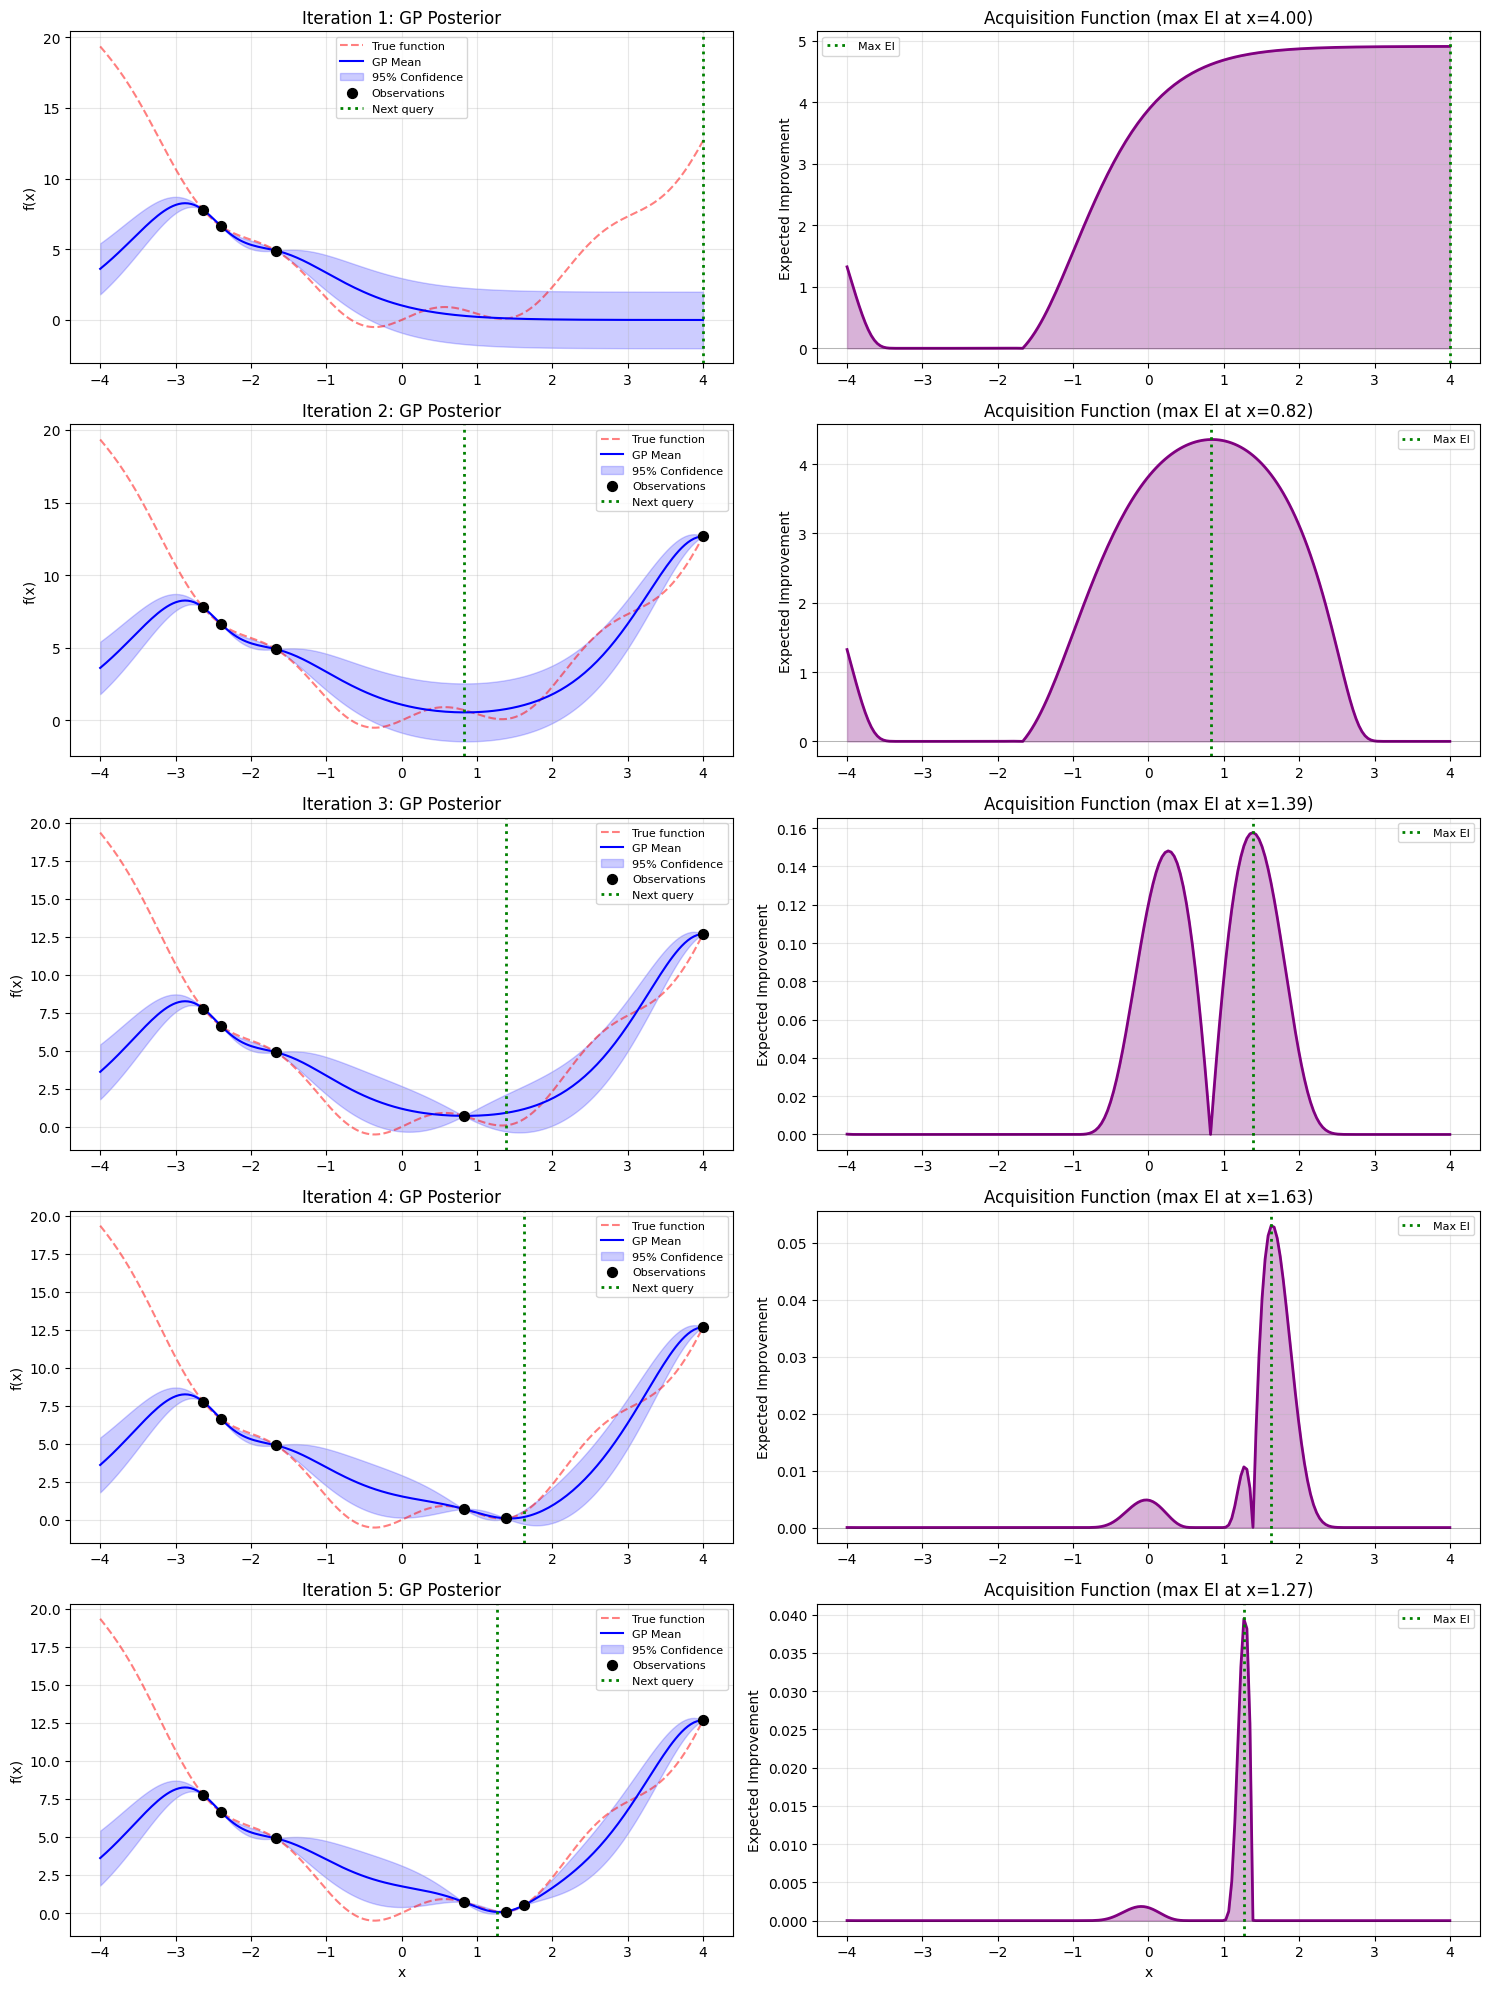


Final result: f* = 0.1010 at x = 1.3869
True minimum: f* = -0.4988 at x = -0.3417


In [14]:
# --- Detailed visualization showing acquisition function evolution ---
print("\n=== Expected Improvement: Step-by-step visualization ===\n")

X_grid = np.linspace(-4, 4, 200).reshape(-1, 1)
theta = np.array([1.0, 1.0])

# Initialize with random points
rng = np.random.RandomState(1)
init_idx = rng.choice(X_grid.shape[0], size=3, replace=False)
X_obs = X_grid[init_idx]
y_obs = f(X_obs)

# Run 5 iterations with visualization
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for iteration in range(5):
    # Compute GP posterior
    mu, cov = gpposterior(X_grid, X_obs, y_obs, theta, matern52_kernel)
    std = np.sqrt(np.maximum(np.diag(cov), 0))
    
    # Compute Expected Improvement - FIX: pass y_obs correctly
    alpha = expected_improvement(mu=mu.flatten(), cov=cov, y_obs=y_obs)
    
    # Find next point
    x_idx = np.argmax(alpha)
    x_next = X_grid[x_idx:x_idx+1]
    
    # Plot GP posterior
    ax = axes[iteration, 0]
    ax.plot(X_grid, true_y, 'r--', alpha=0.5, label='True function')
    ax.plot(X_grid, mu, 'b-', label='GP Mean')
    ax.fill_between(X_grid.flatten(), mu.flatten() - 2*std, mu.flatten() + 2*std,
                     color='blue', alpha=0.2, label='95% Confidence')
    ax.scatter(X_obs, y_obs, c='black', s=50, zorder=10, label='Observations')
    ax.axvline(x_next, color='green', linestyle=':', linewidth=2, label='Next query')
    ax.set_ylabel('f(x)')
    ax.set_title(f'Iteration {iteration+1}: GP Posterior')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    
    # Plot acquisition function
    ax = axes[iteration, 1]
    ax.plot(X_grid, alpha, 'purple', linewidth=2)
    ax.axvline(x_next, color='green', linestyle=':', linewidth=2, label='Max EI')
    ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.fill_between(X_grid.flatten(), 0, alpha, color='purple', alpha=0.3)
    ax.set_ylabel('Expected Improvement')
    ax.set_title(f'Acquisition Function (max EI at x={x_next[0][0]:.2f})')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    
    # Evaluate and add new observation
    y_next = f(x_next)
    X_obs = np.vstack([X_obs, x_next])
    y_obs = np.vstack([y_obs, y_next])

# Set common x-label for bottom plots
axes[-1, 0].set_xlabel('x')
axes[-1, 1].set_xlabel('x')

plt.tight_layout()
plt.show()

print(f"\nFinal result: f* = {np.min(y_obs):.4f} at x = {X_obs[np.argmin(y_obs)][0]:.4f}")
print(f"True minimum: f* = {true_minimum_value:.4f} at x = {true_minimum_x[0]:.4f}")

**Question 3**
*Contrast expected improvement with Thompson sampling, how do they explore the domain differently?*

**Answer**
Thompson Sampling is a stochastic strategy, it has high variance between iterations. In contrast EI is a deterministic approach given the same GP posterior. The algorithm scores each location analytically by the expected utility function defined above. It doesn't sample like in the case of TS but rather it integrates the posterior at each discretised point of our domain. The function explicitly balances between exploitation and exploration, as in, the EI score takes into account good candidate positions using the mean and areas of high uncertainty. In general, EI should be more stable and more predictable.


### Experiments



We are now going to run some experiments to try and learn more about the Bayesian optimisation loop. So far we have looked at 1-dimensional function. The function is actually too easy for the methods that we have and some of the changes that we would have expected between the different experiments might not be as evident as we would like. You can therefore try the two-dimensional Rosenbrock function and make your arguments on that function instead.

The methodology have several different choices and several sources of stochasticity. To understand how this effects the loop we will do a plot called a *regret* plot. In this plot the `x-axis` is the number of function evaluations and the `y-axis` is the current regret. The regret is defined as the difference between the current best value and the optimal value in the set. Given that the functions that we are working here are quite cheap to compute you can just evaluate the function over the whole set to get the optimal value. Given that we have stochasticity in the loop different runs will lead to difference curves therefore plot the mean and two standard deviations for each iterations. It is also quite useful to know the best and worst value that you get so also plot these.

The first experiment that we are going to look at is the effect of the co-variance parameters. The easiest one to see is to look at the length-scale parameter. Generate a regret plot, where you change the length-scale from a very small value to a very large. For this experiment we will fix the stochasticity in the system so before you run the experiment set the random seed in `numpy` using `np.random.seed(42)`. This means that you only need to do a single run for each of the setting.

In [ ]:
# # Define 2D Rosenbrock wrapper
# def rosenbrock_2d(X):
#     """Rosenbrock function for 2D input"""
#     if X.ndim == 1:
#         X = X.reshape(1, -1)
#     x1, x2 = X[:, 0], X[:, 1]
#     result = (1 - x1)**2 + 100 * (x2 - x1**2)**2
#     return result.reshape(-1, 1)
def rosenbrock_2d(X, noise=0.0):
    """Rosenbrock function for 2D input with optional noise"""
    X = np.atleast_2d(X)
    f = np.apply_along_axis(rosen, 1, X).reshape(-1, 1)
    return f + noise * np.random.randn(f.shape[0], 1) if noise > 0 else f

In [ ]:
def compute_regret_curve_2d(kernel, theta, acquisition_function, X_grid, x1_vals, x2_vals, f, n_init=5, n_iter=30, seed=42):
    rng = np.random.RandomState(seed)
    
    f_vals_all = f(X_grid)
    f_min_true = np.min(f_vals_all)
    
    init_idx = rng.choice(X_grid.shape[0], size=n_init, replace=False)
    X_obs = X_grid[init_idx]
    y_obs = f(X_obs)
    
    # All initial observations happen at once, so one regret entry
    regret = [np.min(y_obs) - f_min_true]
    
    observed_indices = set(init_idx)
    
    for _ in range(n_iter):
        mu, cov = gpposterior(X_grid, X_obs, y_obs, theta, kernel, jitter=1e-5)
        alpha = acquisition_function(mu=mu.flatten(), cov=cov, y_obs=y_obs)
        
        alpha_masked = alpha.copy()
        for idx in observed_indices:
            alpha_masked[idx] = -np.inf
        
        x_idx = np.argmax(alpha_masked)
        observed_indices.add(x_idx)
        
        x_next = X_grid[x_idx:x_idx+1]
        y_next = f(x_next)
        
        X_obs = np.vstack([X_obs, x_next])
        y_obs = np.vstack([y_obs, y_next])
        
        current_best = np.min(y_obs)
        regret.append(current_best - f_min_true)
    
    return np.array(regret)

Grid size: 900 points

=== Running lengthscale experiments ===

Testing lengthscale = 0.00...
  Final regret: 537.7741

Testing lengthscale = 0.10...
  Final regret: 1.9595

Testing lengthscale = 0.30...
  Final regret: 0.0000

Testing lengthscale = 0.50...
  Final regret: 0.0000

Testing lengthscale = 1.00...
  Final regret: 0.3351

Testing lengthscale = 1.50...
  Final regret: 1.5828

Testing lengthscale = 2.00...
  Final regret: 0.3995

Testing lengthscale = 3.00...
  Final regret: 0.3351

Testing lengthscale = 5.00...
  Final regret: 0.3995

Testing lengthscale = 10.00...
  Final regret: 1.9966

Testing lengthscale = 20.00...
  Final regret: 0.3995

Testing lengthscale = 100.00...
  Final regret: 238.6115



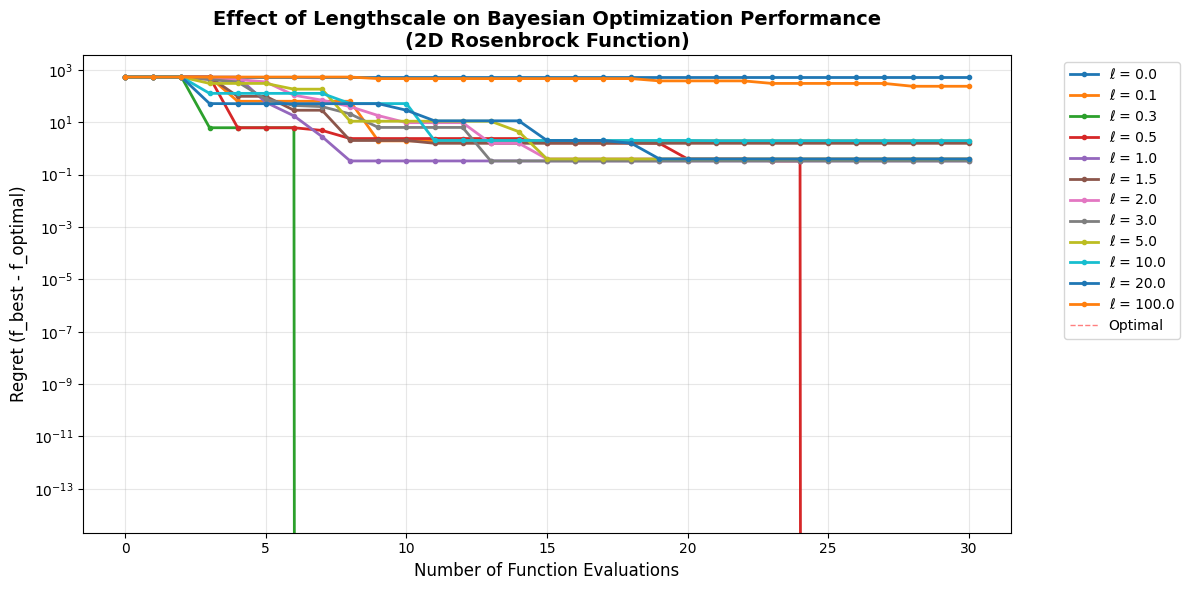

Lengthscale  Final Regret    Min Regret     
0.001        537.7741        537.7741       
0.100        1.9595          1.9595         
0.300        0.0000          0.0000         
0.500        0.0000          0.0000         
1.000        0.3351          0.3351         
1.500        1.5828          1.5828         
2.000        0.3995          0.3995         
3.000        0.3351          0.3351         
5.000        0.3995          0.3995         
10.000       1.9966          1.9966         
20.000       0.3995          0.3995         
100.000      238.6115        238.6115       


In [18]:
n_grid = 30
x1_vals = np.linspace(-3, 3, n_grid)
x2_vals = np.linspace(-3, 3, n_grid)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
X_grid = np.c_[X1.ravel(), X2.ravel()]

print(f"Grid size: {X_grid.shape[0]} points")

lengthscales = [0.001, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0, 20.0, 100.0]
n_init = 3
n_iter = 30
variance = 1.0

# Fix random seed for reproducibility
np.random.seed(42)

print("\n=== Running lengthscale experiments ===\n")

regret_curves = {}
for ls in lengthscales:
    print(f"Testing lengthscale = {ls:.2f}...")
    theta = np.array([variance, ls])
    
    regret = compute_regret_curve_2d(
        kernel=matern52_kernel,
        theta=theta,
        acquisition_function=expected_improvement,
        X_grid=X_grid,
        x1_vals=x1_vals,
        x2_vals=x2_vals,
        f=rosenbrock_2d,
        n_init=n_init,
        n_iter=n_iter,
        seed=42
    )
    
    regret_curves[ls] = regret
    print(f"  Final regret: {regret[-1]:.4f}\n")

# Plot regret curves
plt.figure(figsize=(12, 6))

for ls in lengthscales:
    n_evals = np.arange(len(regret_curves[ls]))
    plt.plot(n_evals, regret_curves[ls], marker='o', markersize=3, 
             label=f'ℓ = {ls:.1f}', linewidth=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Optimal')
plt.xlabel('Number of Function Evaluations', fontsize=12)
plt.ylabel('Regret (f_best - f_optimal)', fontsize=12)
plt.title('Effect of Lengthscale on Bayesian Optimization Performance\n(2D Rosenbrock Function)', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
plt.yscale('log') 
plt.tight_layout()
plt.show()

print(f"{'Lengthscale':<12} {'Final Regret':<15} {'Min Regret':<15}")
for ls in lengthscales:
    final_regret = regret_curves[ls][-1]
    min_regret = np.min(regret_curves[ls])
    print(f"{ls:<12.3f} {final_regret:<15.4f} {min_regret:<15.4f}")

**Question 4**
*Explain why the regret plot looks the way it does. Reason about what the "optimal" lengthscale would be, say that your function is a sample from a GP with lengtscale $\ell$ would having the same lengthscale be the optimal lengthscale for the surrogate? Explain your reasoning.*

**Answer**
The regret plot shows different behaviours across different orders of magnitude of the lengthscale. This plot shows the impact of lengthscale on BO performance.

Very small lengthscales perform extremely poorly, for 0.001, we are essentially treating the observations as independent points with no generalisation/correlation whatsover between points. The GP under this magnitude of lengthscale is extremely myopic and struggles to make meaningdful queries. In fact points only correlate within $\ell$ distance of each other, meaning each observation only affects a tiny neighbourhood. Logically then, when we are away from the observations, the GP posterior variances returns to prior variance, and the mean returns to prior mean, which is often set to be zero. This results in isolated spikes of knowledge aronud each observation with no smooth interpolation.

The sweet spot seems to be between 0.3 and 1.0, and between 3.0 and 5.0, with the best values being 0.3 and 0.5. In these ranges, the lengthscale balances smoothness and the local structure allowing the GP to generalise appropriately while maintaining uncert in unseen regions. This enables exploration and exploitation trade offs.

At large lengthscales, the BO performs egregiously again. Large lengthscales oover smooth the surrogate, and treat distant points as highlly correlated. This completely ignores the narrow valleys of the rosenbock 2d function. The resulting acquisition fn is flat and causes slow convergence.

If the Rosenbrock were a GP sample w lengthscale $\ell$, using the same $\ell$ wouldn't be ideal for optimisation. Our goal with BO is to find the minimum efficiently and not to remodel the function perfectly. In fact a slightly smaller lengthscale will help us by maintaining uncertainty to encourage exploration.



Now lets pick a lengthscale that seems sensible and fix the surrogate model. We are going to look at the stochastic part of the loop and look at the effect of the initial start locations. Lets first play with the number of start locations. Do a regret plot where you show the total evaluations of the function on the x-axis including the number of starting locations. Because we are picking the start locations randomly you will have do multiple runs for each value and your regret plot will therefore have a variance.

Testing n_init = 1 with 20 runs...
  Completed 20 runs

Testing n_init = 2 with 20 runs...
  Completed 20 runs

Testing n_init = 3 with 20 runs...
  Completed 20 runs

Testing n_init = 5 with 20 runs...
  Completed 20 runs

Testing n_init = 7 with 20 runs...
  Completed 20 runs

Testing n_init = 10 with 20 runs...
  Completed 20 runs



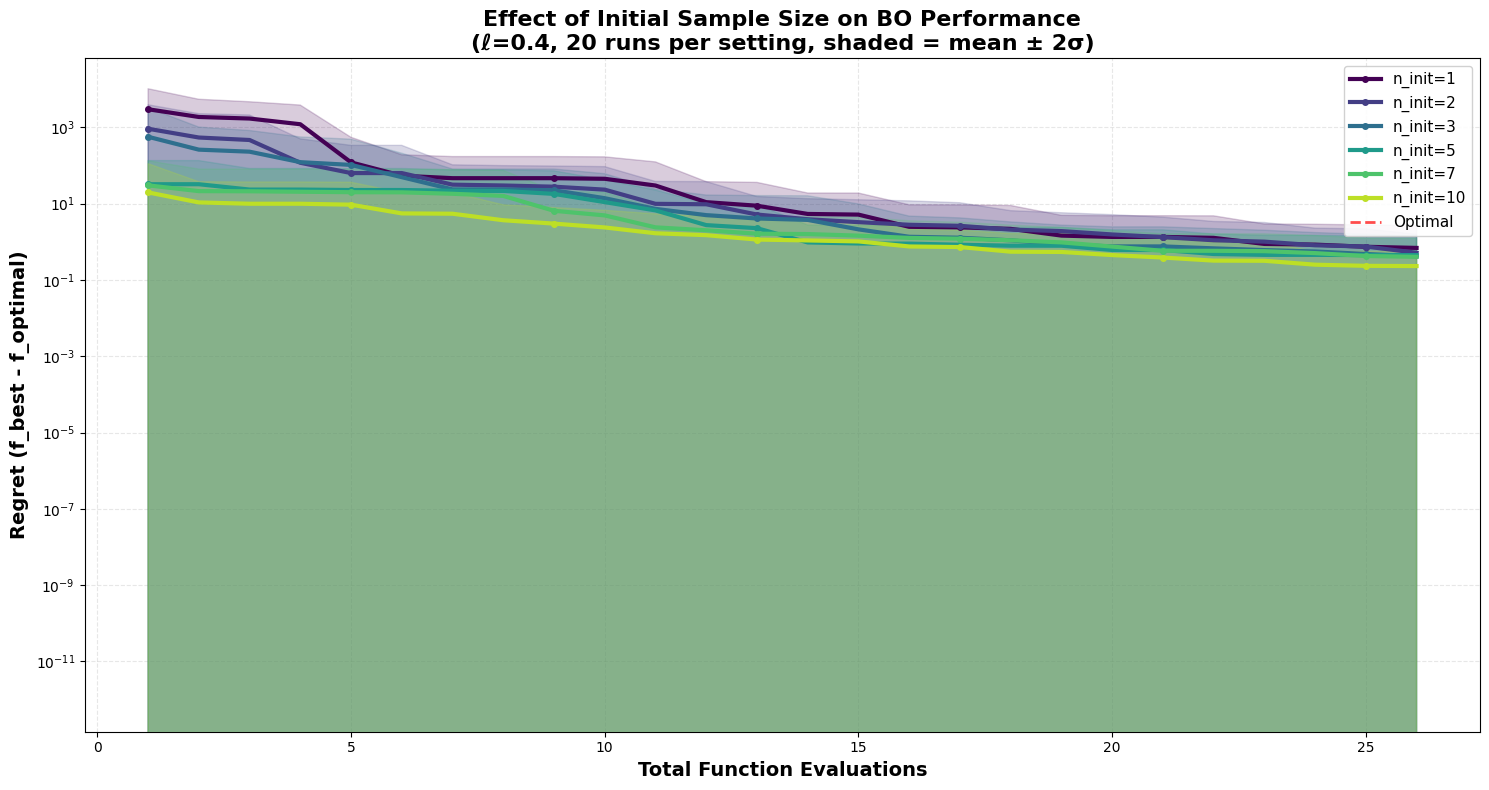

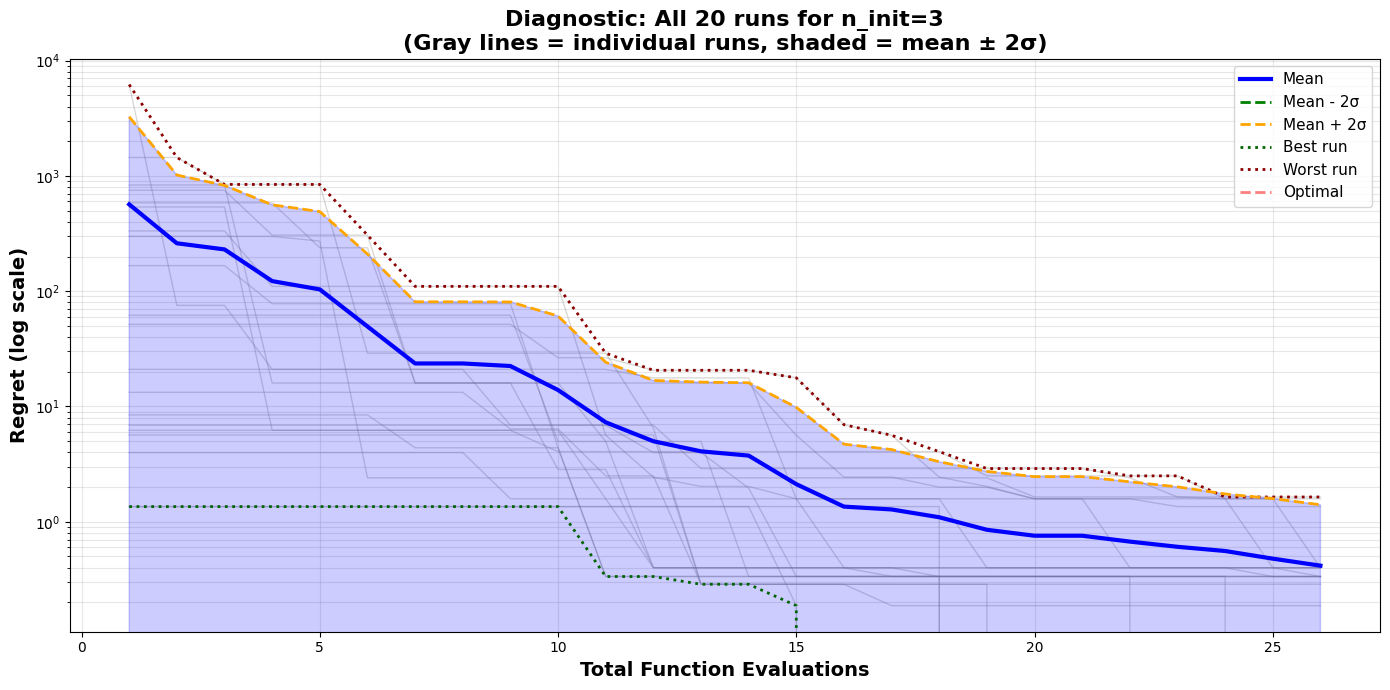


n_init   Final Mean   Final Std    Best Run     Worst Run   
1        6.9139e-01   9.7620e-01   0.0000e+00   4.0600e+00  
2        5.1614e-01   5.2703e-01   0.0000e+00   1.6409e+00  
3        4.1631e-01   4.9415e-01   0.0000e+00   1.6409e+00  
5        4.4858e-01   4.9633e-01   0.0000e+00   1.5828e+00  
7        4.0420e-01   4.1789e-01   0.0000e+00   1.5828e+00  
10       2.3109e-01   1.6225e-01   0.0000e+00   3.9952e-01  


In [32]:
# Choose sensible lengthscale from previous experiment
optimal_lengthscale = 0.4
theta_fixed = np.array([1.0, optimal_lengthscale])

# Experiment parameters
n_init_values = [1, 2, 3, 5, 7, 10]
n_iter = 25
n_runs = 20

# Run experiments
all_regret_curves = {}

for n_init in n_init_values:
    print(f"Testing n_init = {n_init} with {n_runs} runs...")
    regret_runs = []
    
    for run in range(n_runs):
        regret = compute_regret_curve_2d(
            kernel=matern52_kernel,
            theta=theta_fixed,
            acquisition_function=expected_improvement,
            X_grid=X_grid,
            x1_vals=x1_vals,
            x2_vals=x2_vals,
            f=rosenbrock_2d,
            n_init=n_init,
            n_iter=n_iter,
            seed=42 + run
        )
        regret_runs.append(regret)
    
    all_regret_curves[n_init] = np.array(regret_runs)
    print(f"  Completed {n_runs} runs\n")

# ============================================================================
# MAIN COMPARISON PLOT WITH VARIANCE BANDS
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 8))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(n_init_values)))

for idx, n_init in enumerate(n_init_values):
    regret_array = all_regret_curves[n_init]
    n_evals = np.arange(1, regret_array.shape[1] + 1)
    
    # Compute statistics
    mean_regret = np.mean(regret_array, axis=0)
    std_regret = np.std(regret_array, axis=0)
    
    # Mean ± 2 standard deviations (approximately 95% for normal distribution)
    lower_bound = mean_regret - 2 * std_regret
    upper_bound = mean_regret + 2 * std_regret
    
    # Plot mean line (bold)
    ax.plot(n_evals, mean_regret, linewidth=3, color=colors[idx], 
            label=f'n_init={n_init}', marker='o', markersize=4, markevery=4, zorder=10)
    
    # Plot mean ± 2σ confidence interval (shaded)
    ax.fill_between(n_evals, lower_bound, upper_bound,
                     alpha=0.2, color=colors[idx], zorder=5)

ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Optimal', zorder=1)
ax.set_xlabel('Total Function Evaluations', fontsize=14, fontweight='bold')
ax.set_ylabel('Regret (f_best - f_optimal)', fontsize=14, fontweight='bold')
ax.set_title(f'Effect of Initial Sample Size on BO Performance\n(ℓ={optimal_lengthscale}, {n_runs} runs per setting, shaded = mean ± 2σ)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--', which='both')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# ============================================================================
# DIAGNOSTIC PLOT: Show individual runs for one n_init value
# ============================================================================
diagnostic_n_init = 3
fig, ax = plt.subplots(figsize=(14, 7))

regret_array = all_regret_curves[diagnostic_n_init]
n_evals = np.arange(1, regret_array.shape[1] + 1)

# Plot ALL individual runs (semi-transparent)
for run_idx in range(regret_array.shape[0]):
    ax.plot(n_evals, regret_array[run_idx], alpha=0.3, color='gray', linewidth=1)

# Overlay statistics
mean_regret = np.mean(regret_array, axis=0)
std_regret = np.std(regret_array, axis=0)
best_regret = np.min(regret_array, axis=0)
worst_regret = np.max(regret_array, axis=0)

ax.plot(n_evals, mean_regret, linewidth=3, color='blue', label='Mean', zorder=10)
ax.plot(n_evals, mean_regret - 2*std_regret, linewidth=2, color='green', linestyle='--', label='Mean - 2σ', zorder=9)
ax.plot(n_evals, mean_regret + 2*std_regret, linewidth=2, color='orange', linestyle='--', label='Mean + 2σ', zorder=9)
ax.fill_between(n_evals, mean_regret - 2*std_regret, mean_regret + 2*std_regret,
                 alpha=0.2, color='blue', zorder=5)
ax.plot(n_evals, best_regret, linewidth=2, color='darkgreen', linestyle=':', label='Best run', zorder=8)
ax.plot(n_evals, worst_regret, linewidth=2, color='darkred', linestyle=':', label='Worst run', zorder=8)

ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Optimal')
ax.set_xlabel('Total Function Evaluations', fontsize=14, fontweight='bold')
ax.set_ylabel('Regret (log scale)', fontsize=14, fontweight='bold')
ax.set_title(f'Diagnostic: All {n_runs} runs for n_init={diagnostic_n_init}\n(Gray lines = individual runs, shaded = mean ± 2σ)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3, which='both')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "="*90)
print(f"{'n_init':<8} {'Final Mean':<12} {'Final Std':<12} {'Best Run':<12} {'Worst Run':<12}")
print("="*90)
for n_init in n_init_values:
    regret_array = all_regret_curves[n_init]
    final_regrets = regret_array[:, -1]
    
    final_mean = np.mean(final_regrets)
    final_std = np.std(final_regrets)
    best_run = np.min(final_regrets)
    worst_run = np.max(final_regrets)
    
    print(f"{n_init:<8} {final_mean:<12.4e} {final_std:<12.4e} {best_run:<12.4e} {worst_run:<12.4e}")
print("="*90)

In [ ]:
# ============================================================================
# DIAGNOSTIC PLOT: Show individual runs for one n_init value
# ============================================================================
diagnostic_n_init = 3
fig, ax = plt.subplots(figsize=(14, 7))

regret_array = all_regret_curves[diagnostic_n_init]
n_evals = np.arange(1, regret_array.shape[1] + 1)

# Plot ALL individual runs (semi-transparent)
for run_idx in range(regret_array.shape[0]):
    ax.plot(n_evals, regret_array[run_idx], alpha=0.3, color='gray', linewidth=1)

# Overlay statistics
mean_regret = np.mean(regret_array, axis=0)
lower_bound = np.percentile(regret_array, 2.5, axis=0)
upper_bound = np.percentile(regret_array, 97.5, axis=0)
best_regret = np.min(regret_array, axis=0)
worst_regret = np.max(regret_array, axis=0)

ax.plot(n_evals, mean_regret, linewidth=3, color='blue', label='Mean', zorder=10)
ax.plot(n_evals, lower_bound, linewidth=2, color='green', linestyle='--', label='2.5th percentile', zorder=9)
ax.plot(n_evals, upper_bound, linewidth=2, color='orange', linestyle='--', label='97.5th percentile', zorder=9)
ax.plot(n_evals, best_regret, linewidth=2, color='darkgreen', linestyle=':', label='Best run', zorder=8)
ax.plot(n_evals, worst_regret, linewidth=2, color='darkred', linestyle=':', label='Worst run', zorder=8)

ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Optimal')
ax.set_xlabel('Total Function Evaluations', fontsize=14, fontweight='bold')
ax.set_ylabel('Regret (log scale)', fontsize=14, fontweight='bold')
ax.set_title(f'Diagnostic: All {n_runs} runs for n_init={diagnostic_n_init}\n(Gray lines = individual runs)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3, which='both')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

Finally generate a regret plot with lots of runs for $3$ starting locations. 

**Question 5**
*Explain the plots that you see and why you see the behaviour that you do.*

**Answers**

Let us try make the function a bit more challenging by adding a bit of noise to the function. We will keep the number of starting locations to $3$.



In [20]:
# implement a loop that tries different noise-levels
for i in range(0, 10):
    y = f(x, noise[i])
    for j in range(0, n_starts):
        for k in range(0, n_evals):

_IncompleteInputError: incomplete input (3838271219.py, line 5)

Finally make a final experiment where you use a surrogate model that matches the amount of noise as you add to the data.

As you probably noticed the effect of the hyper-parameters is quite significant. Explain how you think we should approach a problem where we are uncertain about the hyper-parameters? One approach would be to actually updated the hyper-parameters with a gradient based optimiser as we did in the last part of the previous lab. However, you do not need to do this as it is going to add a lot of computations as you are doing this inside the inner-loop and with the computational issues that you saw in the last lab it we need to think about numerical stability before we do this. Instead try to reason about it, don't worry about right or wrong here, I just want to hear your thoughts around this issue.

**Question 6**
*What do you think is a good strategy for dealing with the hyper-parameters of the model?*

**Answer**

